In [1]:
import litebird_sim as lbs
import numpy as np
import healpy as hp
from dataclasses import asdict
import matplotlib.pyplot as plt
import time

%matplotlib inline

In [2]:
nside = 64
mission_time_is_sec = 24 * 3600 * 10 # 200 if you want to make a map
instrument = "MFT"
channel = "M1-140"
sampling = 1  # this replaces channelinfo.sampling_rate_hz

In [3]:
imo = lbs.Imo()
sim = lbs.Simulation(
    base_path="./tutorial",
    start_time=0,
    duration_s=mission_time_is_sec,
)

In [36]:
mft_file = sim.imo.query("/releases/v1.3/satellite/"+instrument+"/instrument_info")
sim.generate_spin2ecl_quaternions(
    imo_url="/releases/v1.3/satellite/scanning_parameters/"
)

instrumentinfo = lbs.InstrumentInfo.from_imo(
    imo, f"/releases/v1.3/satellite/{instrument}/instrument_info"
)

channelinfo = lbs.FreqChannelInfo.from_imo(
    url="/releases/v1.3/satellite/" + instrument + "/" + channel + "/channel_info",
    imo=imo,
)
hwp_radpsec = lbs.IdealHWP(instrumentinfo.hwp_rpm * 2 * np.pi / 60,).ang_speed_radpsec

[2022-10-28 10:08:37,155 WARNING MPI#0000] Band is not apodized


In [5]:
dets = []
detquats = []

for detname in (
    "001_003_030_00A_140_T", 
    "001_003_030_00A_140_B"
):  # we choose the couple of detector at the MFT boresight
    det = lbs.DetectorInfo.from_imo(
        url="/releases/v1.3/satellite/"
        + instrument
        + "/"
        + channel
        + "/"
        + detname
        + "/detector_info",
        imo=imo,
    )
    det.sampling_rate_hz = sampling
    dets.append(det)
    detquats.append(det.quat)

[2022-10-28 09:53:01,180 WARNING MPI#0000] Band is not apodized
[2022-10-28 09:53:01,182 WARNING MPI#0000] Band is not apodized


## Create file with HWP non-ideal parameters for MFT
#### The files 'M/HFT_Mesh_HWP_v2.txt' are given from the simulated HWP profiles at https://wiki.kek.jp/download/attachments/123338913/2019_06_22_MFT_HFT_HWP_GP_to_LB_team.xlsx?version=1&modificationDate=1585750021431&api=v2. We read the MFT one to convert the parameters in the way defined in Giardiello et al.

In [6]:
mft = np.loadtxt("MFT_Mesh_HWP_v2.txt")

nu = mft[:, 0]
h1 = np.sqrt(mft[:, 1]) - 1.0
h2 = np.sqrt(mft[:, 3]) - 1.0
beta = mft[:, 5] - 180.0
z1 = 0.01 * np.ones_like(nu)
z2 = 0.01 * np.ones_like(nu)

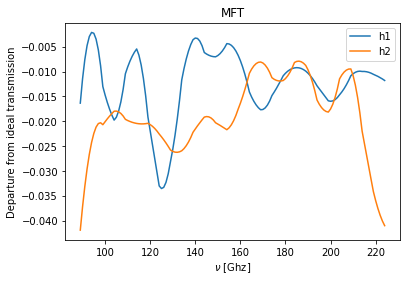

In [13]:
plt.plot(nu, h1, label="h1")
plt.plot(nu, h2, label="h2")
plt.xlabel(r"$\nu$ [Ghz]")
plt.ylabel("Departure from ideal transmission")
plt.title("MFT")
plt.legend()

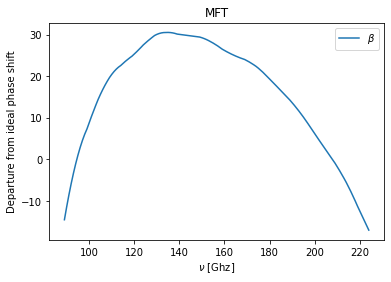

In [14]:
plt.plot(nu, beta, label=r"$\beta$")
plt.xlabel(r"$\nu$ [Ghz]")
plt.ylabel("Departure from ideal phase shift")
plt.title("MFT")
plt.legend()

for the purpose of this exercise, let's focus on the frequencies of the 100 GHz band (89,111)

In [7]:
i_i = np.where(nu == 119-22)[0][0]
i_f = np.where(nu == 161+23)[0][0]
Nu = nu[i_i:i_f]
H1 = h1[i_i:i_f]
H2 = h2[i_i:i_f]
Beta = beta[i_i:i_f]
Z1 = z1[i_i:i_f]
Z2 = z2[i_i:i_f]

In [8]:
np.savetxt("MFT_140_h_beta_z_wider.txt", np.column_stack((Nu, H1, H2, Beta, Z1, Z2)),
           header = '# nu   h1   h2   beta   z1   z2')

#### let's build a top-hat bandpass

In [9]:
from litebird_sim import BandPassInfo

In [9]:
B0 = BandPassInfo(
        bandcenter_ghz= 140,
        bandwidth_ghz=42,
        bandlow_ghz = Nu[0],
        bandhigh_ghz = Nu[-1],
        nsamples_inband=Nu.size,
        name="top-hat ",
    )

[2022-10-26 10:18:09,414 WARNING MPI#0000] Band is not apodized


In [10]:
B0.freqs_ghz

array([ 97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106., 107.,
       108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118.,
       119., 120., 121., 122., 123., 124., 125., 126., 127., 128., 129.,
       130., 131., 132., 133., 134., 135., 136., 137., 138., 139., 140.,
       141., 142., 143., 144., 145., 146., 147., 148., 149., 150., 151.,
       152., 153., 154., 155., 156., 157., 158., 159., 160., 161., 162.,
       163., 164., 165., 166., 167., 168., 169., 170., 171., 172., 173.,
       174., 175., 176., 177., 178., 179., 180., 181., 182., 183.])

In [11]:
B0.get_edges()

(119.0, 161.0)

In [12]:
B0.freqs_ghz[np.where(B0.weights == 1)[0]]

array([119., 120., 121., 122., 123., 124., 125., 126., 127., 128., 129.,
       130., 131., 132., 133., 134., 135., 136., 137., 138., 139., 140.,
       141., 142., 143., 144., 145., 146., 147., 148., 149., 150., 151.,
       152., 153., 154., 155., 156., 157., 158., 159., 160., 161.])

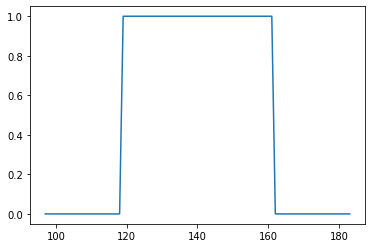

In [13]:
plt.plot(B0.freqs_ghz,B0.weights)

for a bandpass with exponentially decaying wings:

In [14]:
Bexp = BandPassInfo(
        bandcenter_ghz= 140,
        bandwidth_ghz=42,
        bandlow_ghz = Nu[0],
        bandhigh_ghz = Nu[-1],
        nsamples_inband=Nu.size,
        bandtype="top-hat-exp",
        normalize=False,
       alpha_exp = 0.9,
       beta_exp = 0.9
    )

[2022-10-25 15:59:05,361 WARNING MPI#0000] Apodizing w/ exp profile


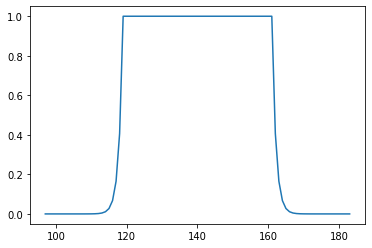

In [15]:
plt.plot(Bexp.freqs_ghz, Bexp.weights)

for a bandpass with cosine apodization


In [16]:
Bcos = BandPassInfo(
        bandcenter_ghz= 140,
        bandwidth_ghz=42,
        bandlow_ghz = Nu[0],
        bandhigh_ghz = Nu[-1],
        nsamples_inband=Nu.size,
        bandtype="top-hat-cosine",
        normalize=False,
       cosine_apo_length =2
    )

[2022-10-25 15:59:07,534 WARNING MPI#0000] Apodizing w/ cosine profile


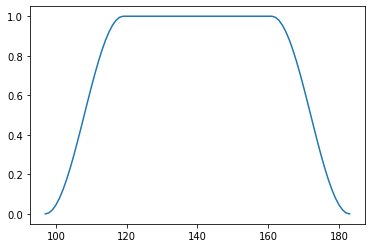

In [17]:
plt.plot(Bcos.freqs_ghz, Bcos.weights)

## Fill tod with a band top-hat + wings

In [15]:
(obs_w,) = sim.create_observations(
    detectors=dets,
    n_blocks_det=1,
    n_blocks_time=1,  # blocks different from one if parallelizing
)

In [16]:
(pointings,) = lbs.get_pointings_for_observations(
    sim.observations,
    spin2ecliptic_quats=sim.spin2ecliptic_quats,
    bore2spin_quat=instrumentinfo.bore2spin_quat,
    hwp= None,
    #lbs.IdealHWP(
    #    inst_info.hwp_rpm * 2 * np.pi / 60,
    #),  # applies hwp rotation angle to the polarization angle
    store_pointings_in_obs=True,  # if True, stores colatitude and longitude in
    # sim.observations[:].pointings, and the polarization angle in
    # sim.observations[:].psi
)

if you are using band integration (`integrate_in_band = True` in `hwp_sys.set_parameters`) you don't need to create a map beforehand, the `set_parameters` function of HwpSys will generate one cmb+fg map for each frequency. The following cell is commented because it is not needed when using band integration

In [12]:
# Mbsparams = lbs.MbsParameters(make_cmb =True,
#                              make_fg = False,
#                              gaussian_smooth = True,
#                              bandpass_int = False,
#                              nside = nside,
#                             )

# mbs = lbs.Mbs(simulation=sim,
#              parameters=Mbsparams,
#              channel_list=channelinfo,
#             )
# maps = mbs.run_all()[0][channel]

[2021-12-30 12:21:37,845 INFO MPI#0000] generating and saving cmb simulations
[2021-12-30 12:21:37,863 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2021-12-30 12:21:38,077 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 12:21:38,077 INFO MPI#0000] -> fwhm is 0.000000 arcmin
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from tutorial/cmb/0000/cmb_0000_date_211230.fits
  warnings.warn(f"Access data from {full_path}")
[2021-12-30 12:21:38,960 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2021-12-30 12:21:38,963 INFO MPI#0000] NSIDE = 512
[2021-12-30 12:21:38,963 INFO MPI#0000] ORDERING = RING in fits file
[2021-12-30 12:21:38,964 INFO MPI#0000] INDXSCHM = IMPLICIT


***************** D
***************** D
***************** D


[2021-12-30 12:21:39,725 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2021-12-30 12:21:44,631 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2021-12-30 12:21:44,632 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2021-12-30 12:21:44,676 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 12:21:44,676 INFO MPI#0000] -> fwhm is 0.000000 arcmin


In [39]:
par = {
    "hwp_sys": {
        "band_filename": "MFT_140_h_beta_z_wider.txt",
        "band_filename_solver": "MFT_140_h_beta_z_wider.txt",  # same as tod parameters
        "bandpass": {
            "band_type": "top-hat-exp",
            "band_alpha": 0.9,
            "band_beta": 0.9,
            "band_low_edge": 119,
            "band_high_edge": 161,
            "bandcenter_ghz": channelinfo.bandcenter_ghz,
        },
        "bandpass_solver": {
            "band_type": "top-hat",
            "band_low_edge": 119,
            "band_high_edge": 161,
            "bandcenter_ghz": channelinfo.bandcenter_ghz,
        },
        "include_beam_throughput": False,
    }
}

In [40]:
sim.parameter_file = par  # setting the parameter file
hwp_sys_band = lbs.HwpSysAndBandpass(sim)

Let's initialise Mbsparams in order to set a seed for the cmb map. The FG is always the same. 
It's important input maps are generated in galactic coordinates (mbs defaults), since the pointing is rotated from ecliptic to galactic coordinates

In [8]:
Mbsparams = lbs.MbsParameters(
    make_cmb=True,
    make_fg=True,
    fg_models=["pysm_synch_1", "pysm_freefree_1", "pysm_dust_1", "pysm_ame_1"],
    bandpass_int=False,
    maps_in_ecliptic=False,
    gaussian_smooth = True,
    seed_cmb=1234,
    nside=nside,
)

the next command will take a while with band integration, since it has to generate one map per frequency

In [41]:
hwp_sys_band.set_parameters(  # maps=maps,    # ---> to use without band integration
    integrate_in_band=True,
    integrate_in_band_solver=True,
    correct_in_solver=True,
    built_map_on_the_fly=False,
    nside=nside,
    Mbsparams=Mbsparams,
    Channel=channelinfo,
)

[2022-10-27 18:13:09,324 WARNING MPI#0000] Apodizing w/ exp profile
[2022-10-27 18:13:09,326 INFO MPI#0000] using the passed instrument to generate maps
[2022-10-27 18:13:09,327 INFO MPI#0000] generating and saving cmb simulations
[2022-10-27 18:13:09,339 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:13:09,339 INFO MPI#0000] -> fwhm is 0.000000 arcmin
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /home/sgiardie/lbs/out_of_band/litebird_sim/litebird_sim/out_of_band_analysis/examples/tutorial/cmb/0000/cmb_0000_date_221027.fits
  warnings.warn(f"Access data from {full_path}")
[2022-10-27 18:13:09,414 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2022-10-27 18:13:09,416 INFO MPI#0000] NSIDE = 64
[2022-10-27 18:13:09,417 INFO MPI#0000] ORDERING = RING in fits file
[2022-10-27 18:13:09,417 INFO MPI#0000] INDXSC

***************** D
***************** D
***************** D


[2022-10-27 18:13:09,702 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:13:09,703 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:13:09,704 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:13:09,705 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:13:09,765 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:13:09,766 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:13:09,767 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:13:09,767 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:13:09,822 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:13:09,822 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:13:09,824 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:13:09,824 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:13:09,866 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:13:09,867

[2022-10-27 18:13:11,159 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:13:11,161 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:13:11,223 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:13:11,225 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:13:11,227 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:13:11,229 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:13:11,265 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:13:11,267 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:13:11,269 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:13:11,272 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:13:11,313 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:13:11,315 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:13:11,317 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:13:11,319 

[2022-10-27 18:13:12,520 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:13:12,521 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:13:12,522 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:13:12,522 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:13:12,561 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:13:12,562 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:13:12,564 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:13:12,564 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:13:12,607 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:13:12,608 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:13:12,609 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:13:12,609 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:13:12,645 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:13:12,646

[2022-10-27 18:13:13,754 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:13:13,755 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:13:13,799 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:13:13,800 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:13:13,801 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:13:13,802 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:13:13,895 INFO MPI#0000] generating and saving fg simulations
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
[2022-10-27 18:13:13,898 INFO MPI#0000] NSIDE = 512
[2022-10-27 18:13:13,899 INFO MPI#0000] ORDERING = RING in fits file
[2022-10-27 18:13:13,900 INFO MPI#0000] INDXSCHM = IMPLICIT
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/si

[2022-10-27 18:13:18,005 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:13:18,006 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:13:18,007 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:13:18,164 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:13:18,165 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:13:18,167 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:13:18,167 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:13:18,347 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:13:18,348 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:13:18,349 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:13:18,350 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:13:18,540 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:13:18,541 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:13:18,542 INFO MPI#0000

[2022-10-27 18:13:21,772 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:13:21,933 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:13:21,934 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:13:21,935 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:13:21,935 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:13:22,103 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:13:22,104 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:13:22,105 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:13:22,106 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:13:22,303 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:13:22,305 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:13:22,308 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:13:22,310 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:13:22,484 INFO MPI#0000]

[2022-10-27 18:13:26,530 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:13:26,533 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:13:26,534 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:13:26,702 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:13:26,704 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:13:26,706 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:13:26,708 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:13:26,866 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:13:26,868 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:13:26,870 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:13:26,872 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:13:27,028 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:13:27,029 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:13:27,035 INFO MPI#0000

[2022-10-27 18:13:30,300 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:13:30,301 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:13:30,413 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:13:30,415 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:13:30,417 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:13:30,419 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:13:30,515 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:13:30,517 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:13:30,519 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:13:30,521 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:13:30,629 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:13:30,631 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:13:30,633 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:13:30,635 

[2022-10-27 18:13:33,398 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:13:33,400 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:13:33,403 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:13:33,405 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:13:33,513 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:13:33,515 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:13:33,517 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:13:33,519 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:13:33,632 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:13:33,634 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:13:33,636 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:13:33,638 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:13:33,748 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:13:33,749

[2022-10-27 18:13:36,492 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:13:36,494 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:13:36,628 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:13:36,630 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:13:36,632 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:13:36,635 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:13:36,820 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:13:36,829 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:13:36,831 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:13:36,833 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:13:36,965 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:13:36,972 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:13:36,975 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:13:36,977 

[2022-10-27 18:13:40,740 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:13:40,742 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:13:40,744 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:13:40,746 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:13:40,991 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:13:40,993 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:13:40,995 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:13:40,997 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:13:41,256 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:13:41,258 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:13:41,260 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:13:41,263 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:13:41,514 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:13:41,516

[2022-10-27 18:13:47,769 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:13:47,771 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:13:48,034 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:13:48,036 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:13:48,038 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:13:48,040 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:13:48,287 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:13:48,289 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:13:48,292 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:13:48,294 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:13:48,550 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:13:48,552 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:13:48,554 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:13:48,556 

[2022-10-27 18:13:55,351 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:13:55,352 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:13:55,353 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:13:55,354 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:13:55,622 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:13:55,623 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:13:55,625 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:13:55,625 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:13:55,874 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:13:55,875 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:13:55,876 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:13:55,877 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:13:56,125 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:13:56,126

[2022-10-27 18:14:02,428 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:14:02,430 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:14:02,688 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:14:02,690 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:14:02,693 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:14:02,695 INFO MPI#0000] -> fwhm is 0.000000 arcmin
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/ame_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
[2022-10-27 18:14:02,702 INFO MPI#0000] NSIDE = 512
[2022-10-27 18:14:02,704 INFO MPI#0000] ORDERING = RING in fits file
[2022-10-27 18:14:02,705 INFO MPI#0000] INDXSCHM = IMPLICIT
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/ame_n

[2022-10-27 18:14:06,795 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:14:06,797 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:14:06,799 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:14:06,802 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:14:06,955 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:14:06,957 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:14:06,960 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:14:06,962 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:14:07,118 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:14:07,120 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:14:07,122 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:14:07,125 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:14:07,311 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:14:07,313

[2022-10-27 18:14:11,348 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:14:11,350 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:14:11,514 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:14:11,516 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:14:11,519 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:14:11,522 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:14:11,689 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:14:11,691 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:14:11,693 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:14:11,695 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:14:11,858 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:14:11,864 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:14:11,871 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:14:11,874 

[2022-10-27 18:14:16,053 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:14:16,055 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:14:16,058 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:14:16,060 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:14:16,211 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:14:16,213 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:14:16,216 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:14:16,218 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:14:16,392 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:14:16,394 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:14:16,397 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:14:16,399 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:14:16,576 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:14:16,578

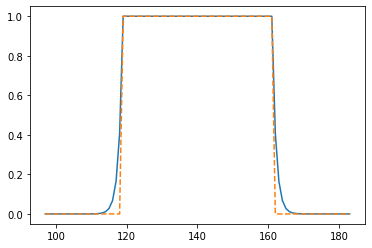

In [14]:
plt.plot(hwp_sys_band.freqs,hwp_sys_band.bandpass_profile, label = 'tod')
plt.plot(hwp_sys_band.freqs,hwp_sys_band.bandpass_profile_solver, ls = '--', label = 'solver')

In [42]:
t_in = time.time()
hwp_sys_band.fill_tod(obs = obs_w, #pointings = pointings, 
                      hwp_radpsec = hwp_radpsec)
t_tod = time.time()
t_tod - t_in
# obs.tod *= 2.0  #this 2 factor is useful only when comparing to the mapmaking in lbs.make_bin_map
# for which the tod is twice as the one computed here

10.300369262695312

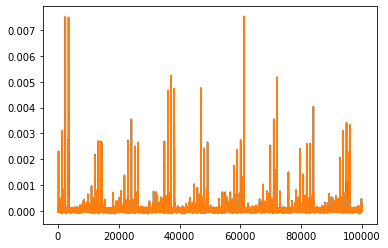

In [43]:
plt.plot(obs_w.tod[0, :100000])
plt.plot(obs_w.tod[1, :100000])

since we have few days of observation, it is pointless to generate a map

# Testing out_of_band_analysis against hwp_sys

Let's take now a top-hat band. We take a band of 1 for all frequencies, in order to compare the result coming from out_of_band_analysis.py to the top-hat band that hwp_sys.py would consider by reading the frequencies in the parameter file `MFT_140_h_beta_z_wider.txt`. In fact, hwp_sys.py assumes the band to be 1 for all its input frequencies

[2022-10-28 09:57:56,238 WARNING MPI#0000] Band is not apodized


Text(0, 0.5, 'transmission')

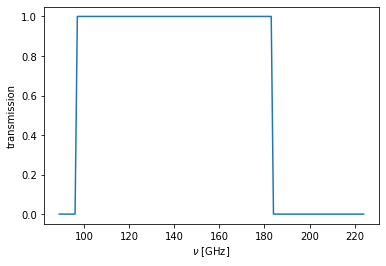

In [13]:
bandpass_parameters={
            'band_type': 'top-hat',
            'band_low_edge': Nu[0],
            'band_high_edge': Nu[-1],
            "bandcenter_ghz": channelinfo.bandcenter_ghz,
            }
transmission=lbs.out_of_band_analysis.bandpass_template_module.bandpass_profile(nu,
                                        bandpass_parameters)
plt.plot(transmission[0],transmission[1])
plt.xlabel(r'$\nu$ [GHz]')
plt.ylabel('transmission')

we generate a clean observation each time we want to compute a new tod

In [17]:
(obs,) = sim.create_observations(detectors=dets)

In [18]:
par = { 'hwp_sys':
       {'band_filename': 'MFT_140_h_beta_z_wider.txt',
        'band_filename_solver': 'MFT_140_h_beta_z_wider.txt',  #same as tod parameters
        'bandpass':{
            'band_type': 'top-hat',
            'band_low_edge': Nu[0],
            'band_high_edge': Nu[-1],
            "bandcenter_ghz": channelinfo.bandcenter_ghz,
            },
        'bandpass_solver':{
            'band_type': 'top-hat',
            'band_low_edge': Nu[0],
            'band_high_edge': Nu[-1],
            "bandcenter_ghz": channelinfo.bandcenter_ghz,
            },
        'include_beam_throughput': False,
       }
      }

In [19]:
sim.parameter_file = par   #setting the parameter file
hwp_sys_band = lbs.HwpSysAndBandpass(sim)

In [20]:
hwp_sys_band.set_parameters(#maps=maps,    # ---> to use without band integration
                       integrate_in_band=True,
                       integrate_in_band_solver=True,
                       correct_in_solver=True,
                       built_map_on_the_fly=False,
                       nside=nside,
                       Mbsparams = Mbsparams,
                       Channel = channelinfo
                      )

[2022-10-28 10:01:30,883 WARNING MPI#0000] Band is not apodized
[2022-10-28 10:01:30,884 INFO MPI#0000] using the passed instrument to generate maps
[2022-10-28 10:01:30,885 INFO MPI#0000] generating and saving cmb simulations
[2022-10-28 10:01:30,896 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:01:30,897 INFO MPI#0000] -> fwhm is 0.000000 arcmin
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /home/sgiardie/lbs/out_of_band/litebird_sim/litebird_sim/out_of_band_analysis/examples/tutorial/cmb/0000/cmb_0000_date_221028.fits
  warnings.warn(f"Access data from {full_path}")
[2022-10-28 10:01:30,973 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2022-10-28 10:01:30,975 INFO MPI#0000] NSIDE = 64
[2022-10-28 10:01:30,976 INFO MPI#0000] ORDERING = RING in fits file
[2022-10-28 10:01:30,977 INFO MPI#0000] INDXSCHM =

***************** D
***************** D
***************** D


[2022-10-28 10:01:31,184 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:01:31,185 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:01:31,186 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:01:31,187 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:01:31,233 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:01:31,234 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:01:31,235 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:01:31,236 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:01:31,282 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:01:31,283 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:01:31,284 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:01:31,285 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:01:31,332 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:01:31,333

[2022-10-28 10:01:32,556 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:01:32,557 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:01:32,591 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:01:32,593 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:01:32,596 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:01:32,598 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:01:32,641 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:01:32,643 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:01:32,646 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:01:32,648 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:01:32,682 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:01:32,684 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:01:32,687 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:01:32,689 

[2022-10-28 10:01:33,784 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:01:33,786 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:01:33,789 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:01:33,791 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:01:33,826 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:01:33,828 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:01:33,830 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:01:33,831 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:01:33,865 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:01:33,867 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:01:33,869 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:01:33,871 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:01:33,903 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:01:33,905

[2022-10-28 10:01:34,732 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:01:34,734 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:01:34,761 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:01:34,763 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:01:34,765 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:01:34,767 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:01:34,846 INFO MPI#0000] generating and saving fg simulations
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
[2022-10-28 10:01:34,887 INFO MPI#0000] NSIDE = 512
[2022-10-28 10:01:34,889 INFO MPI#0000] ORDERING = RING in fits file
[2022-10-28 10:01:34,891 INFO MPI#0000] INDXSCHM = IMPLICIT
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/si

[2022-10-28 10:01:38,727 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:01:38,729 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:01:38,730 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:01:38,773 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:01:38,774 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:01:38,776 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:01:38,776 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:01:38,820 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:01:38,821 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:01:38,824 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:01:38,824 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:01:38,866 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:01:38,867 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:01:38,869 INFO MPI#0000

[2022-10-28 10:01:41,931 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:01:42,102 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:01:42,104 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:01:42,107 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:01:42,109 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:01:42,274 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:01:42,277 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:01:42,279 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:01:42,295 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:01:42,530 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:01:42,532 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:01:42,535 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:01:42,537 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:01:42,748 INFO MPI#0000]

[2022-10-28 10:01:46,758 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:01:46,759 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:01:46,759 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:01:46,931 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:01:46,932 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:01:46,933 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:01:46,933 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:01:47,142 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:01:47,143 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:01:47,144 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:01:47,145 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:01:47,350 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:01:47,351 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:01:47,352 INFO MPI#0000

[2022-10-28 10:01:51,608 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:01:51,610 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:01:51,721 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:01:51,723 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:01:51,725 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:01:51,727 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:01:51,837 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:01:51,838 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:01:51,841 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:01:51,843 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:01:51,956 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:01:51,958 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:01:51,960 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:01:51,962 

[2022-10-28 10:01:54,915 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:01:54,916 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:01:54,918 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:01:54,918 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:01:55,025 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:01:55,026 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:01:55,027 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:01:55,028 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:01:55,147 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:01:55,149 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:01:55,152 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:01:55,153 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:01:55,255 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:01:55,257

[2022-10-28 10:01:57,422 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:01:57,424 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:01:57,477 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:01:57,479 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:01:57,481 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:01:57,483 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:01:57,530 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:01:57,532 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:01:57,534 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:01:57,536 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:01:57,585 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:01:57,587 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:01:57,589 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:01:57,591 

[2022-10-28 10:02:03,025 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:02:03,027 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:02:03,030 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:02:03,031 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:02:03,287 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:02:03,288 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:02:03,289 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:02:03,290 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:02:03,595 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:02:03,597 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:02:03,599 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:02:03,601 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:02:03,866 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:02:03,868

[2022-10-28 10:02:10,158 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:02:10,159 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:02:10,390 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:02:10,392 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:02:10,394 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:02:10,396 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:02:10,575 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:02:10,578 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:02:10,580 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:02:10,582 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:02:10,821 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:02:10,823 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:02:10,826 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:02:10,828 

[2022-10-28 10:02:17,368 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:02:17,370 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:02:17,373 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:02:17,375 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:02:17,626 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:02:17,628 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:02:17,631 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:02:17,633 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:02:17,895 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:02:17,897 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:02:17,899 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:02:17,901 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:02:18,141 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:02:18,143

[2022-10-28 10:02:23,174 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:02:23,175 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:02:23,428 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:02:23,437 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:02:23,441 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:02:23,443 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:02:23,696 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:02:23,702 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:02:23,706 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:02:23,708 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:02:23,959 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:02:23,965 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:02:23,968 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:02:23,971 

[2022-10-28 10:02:32,649 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:02:32,652 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:02:32,655 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:02:32,658 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:02:32,844 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:02:32,846 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:02:32,849 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:02:32,852 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:02:33,064 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:02:33,065 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:02:33,066 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:02:33,068 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:02:33,253 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:02:33,256

[2022-10-28 10:02:37,366 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:02:37,367 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:02:37,549 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:02:37,550 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:02:37,551 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:02:37,563 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:02:37,739 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:02:37,741 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:02:37,743 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:02:37,745 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:02:37,936 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:02:37,939 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:02:37,941 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:02:37,943 

[2022-10-28 10:02:42,416 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:02:42,418 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:02:42,421 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:02:42,422 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:02:42,583 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:02:42,585 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:02:42,588 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:02:42,590 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:02:42,752 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:02:42,753 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:02:42,756 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:02:42,757 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:02:42,912 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:02:42,914

In [21]:
hwp_sys_band.fill_tod(obs = obs,pointings = pointings,hwp_radpsec = hwp_radpsec)

In [24]:
obs.tod

array([[ 3.3290831e-05,  3.0287101e-05,  2.9988711e-05, ...,
        -3.5345220e-06, -2.4136784e-06, -3.2836249e-06],
       [ 3.2189331e-05,  2.9440052e-05,  3.0009409e-05, ...,
        -2.3717162e-06, -3.5288911e-06, -2.6943399e-06]], dtype=float32)


let's create a new simulation, initialise hwp_sys and compute the same kind of tod

In [22]:
sim1 = lbs.Simulation(base_path="./tutorial",
                     start_time=0,
                     duration_s=mission_time_is_sec,
                    )

In [23]:
mft_file = sim1.imo.query("/releases/v1.3/satellite/"+instrument+"/instrument_info")
sim1.generate_spin2ecl_quaternions(imo_url="/releases/v1.3/satellite/scanning_parameters/")

In [25]:
(obs1,) = sim1.create_observations(detectors=dets)

In [26]:
sim1.parameter_file = par
hwp_sys = lbs.HwpSys(sim1)

In [27]:
hwp_sys.set_parameters(#maps=maps,    # ---> to use without band integration
                       integrate_in_band=True,
                       integrate_in_band_solver = True,
                       correct_in_solver=True,
                       built_map_on_the_fly=False,
                       nside=nside,
                        Mbsparams = Mbsparams,
                      Channel = channelinfo
                      )

[2022-10-28 10:03:35,530 INFO MPI#0000] using the passed instrument to generate maps
[2022-10-28 10:03:35,532 INFO MPI#0000] generating and saving cmb simulations
[2022-10-28 10:03:35,549 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:03:35,550 INFO MPI#0000] -> fwhm is 0.000000 arcmin
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /home/sgiardie/lbs/out_of_band/litebird_sim/litebird_sim/out_of_band_analysis/examples/tutorial/cmb/0000/cmb_0000_date_221028.fits
  warnings.warn(f"Access data from {full_path}")
[2022-10-28 10:03:35,588 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2022-10-28 10:03:35,594 INFO MPI#0000] NSIDE = 64
[2022-10-28 10:03:35,594 INFO MPI#0000] ORDERING = RING in fits file
[2022-10-28 10:03:35,595 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-10-28 10:03:35,652 INFO MPI#0000] Sigma is 13.07

***************** D
***************** D
***************** D


[2022-10-28 10:03:35,814 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:03:35,815 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:03:35,816 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:03:35,816 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:03:35,873 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:03:35,873 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:03:35,875 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:03:35,875 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:03:35,935 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:03:35,936 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:03:35,937 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:03:35,938 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:03:35,995 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:03:35,996

[2022-10-28 10:03:37,451 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:03:37,453 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:03:37,494 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:03:37,496 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:03:37,498 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:03:37,500 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:03:37,536 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:03:37,538 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:03:37,540 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:03:37,542 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:03:37,582 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:03:37,584 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:03:37,586 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:03:37,588 

[2022-10-28 10:03:38,591 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:03:38,593 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:03:38,596 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:03:38,598 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:03:38,631 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:03:38,633 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:03:38,636 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:03:38,637 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:03:38,671 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:03:38,674 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:03:38,676 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:03:38,679 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:03:38,712 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:03:38,715

[2022-10-28 10:03:39,718 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:03:39,721 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:03:39,763 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:03:39,765 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:03:39,767 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:03:39,769 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:03:39,854 INFO MPI#0000] generating and saving fg simulations
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
[2022-10-28 10:03:39,858 INFO MPI#0000] NSIDE = 512
[2022-10-28 10:03:39,860 INFO MPI#0000] ORDERING = RING in fits file
[2022-10-28 10:03:39,862 INFO MPI#0000] INDXSCHM = IMPLICIT
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/si

[2022-10-28 10:03:41,778 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:03:41,781 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:03:41,783 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:03:41,840 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:03:41,842 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:03:41,844 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:03:41,846 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:03:41,906 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:03:41,908 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:03:41,910 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:03:41,911 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:03:41,963 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:03:41,964 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:03:41,967 INFO MPI#0000

[2022-10-28 10:03:43,403 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:03:43,447 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:03:43,449 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:03:43,451 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:03:43,452 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:03:43,499 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:03:43,501 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:03:43,503 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:03:43,505 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:03:43,553 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:03:43,555 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:03:43,558 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:03:43,560 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:03:43,605 INFO MPI#0000]

[2022-10-28 10:03:45,487 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:03:45,490 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:03:45,493 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:03:45,617 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:03:45,619 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:03:45,621 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:03:45,624 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:03:45,772 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:03:45,774 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:03:45,776 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:03:45,777 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:03:45,832 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:03:45,834 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:03:45,836 INFO MPI#0000

[2022-10-28 10:03:47,736 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:03:47,738 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:03:47,789 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:03:47,791 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:03:47,793 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:03:47,795 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:03:47,846 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:03:47,848 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:03:47,850 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:03:47,852 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:03:47,900 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:03:47,902 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:03:47,904 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:03:47,906 

[2022-10-28 10:03:50,696 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:03:50,697 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:03:50,698 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:03:50,699 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:03:50,809 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:03:50,810 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:03:50,811 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:03:50,812 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:03:50,914 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:03:50,915 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:03:50,916 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:03:50,917 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:03:51,011 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:03:51,012

[2022-10-28 10:03:52,917 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:03:52,919 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:03:52,981 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:03:52,983 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:03:52,985 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:03:52,988 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:03:53,038 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:03:53,040 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:03:53,045 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:03:53,047 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:03:53,107 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:03:53,109 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:03:53,111 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:03:53,114 

[2022-10-28 10:03:55,818 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:03:55,820 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:03:55,823 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:03:55,825 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:03:56,076 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:03:56,076 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:03:56,079 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:03:56,080 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:03:56,413 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:03:56,414 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:03:56,417 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:03:56,417 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:03:56,729 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:03:56,730

[2022-10-28 10:04:03,128 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:04:03,131 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:04:03,386 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:04:03,388 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:04:03,390 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:04:03,391 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:04:03,631 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:04:03,638 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:04:03,642 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:04:03,644 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:04:03,907 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:04:03,909 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:04:03,911 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:04:03,913 

[2022-10-28 10:04:10,310 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:04:10,312 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:04:10,314 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:04:10,315 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:04:10,581 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:04:10,583 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:04:10,585 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:04:10,586 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:04:10,841 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:04:10,844 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:04:10,846 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:04:10,849 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:04:11,130 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:04:11,133

[2022-10-28 10:04:18,014 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:04:18,015 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:04:18,277 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:04:18,279 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:04:18,281 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:04:18,283 INFO MPI#0000] -> fwhm is 0.000000 arcmin
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/ame_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
[2022-10-28 10:04:18,291 INFO MPI#0000] NSIDE = 512
[2022-10-28 10:04:18,292 INFO MPI#0000] ORDERING = RING in fits file
[2022-10-28 10:04:18,294 INFO MPI#0000] INDXSCHM = IMPLICIT
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/ame_n

[2022-10-28 10:04:22,570 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:04:22,572 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:04:22,574 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:04:22,576 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:04:22,729 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:04:22,731 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:04:22,733 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:04:22,735 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:04:22,919 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:04:22,921 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:04:22,923 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:04:22,925 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:04:23,098 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:04:23,100

[2022-10-28 10:04:27,679 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:04:27,681 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:04:27,846 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:04:27,846 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:04:27,848 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:04:27,853 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:04:28,027 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:04:28,029 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:04:28,032 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:04:28,034 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:04:28,187 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:04:28,190 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:04:28,193 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:04:28,194 

[2022-10-28 10:04:31,509 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:04:31,511 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:04:31,514 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:04:31,516 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:04:31,763 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:04:31,765 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:04:31,767 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:04:31,770 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:04:31,929 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:04:31,931 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-28 10:04:31,934 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-28 10:04:31,935 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-28 10:04:32,105 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-28 10:04:32,107


we see that the maps generated by the two classes are exactly the same

In [28]:
(hwp_sys.maps == hwp_sys_band.maps).all()

True

In [30]:
hwp_sys.fill_tod(obs = obs1,pointings = pointings,hwp_radpsec = hwp_radpsec)

The bands are the same

In [35]:
(hwp_sys.cmb2bb/hwp_sys.norm == hwp_sys_band.cmb2bb).all()

True

In [33]:
(obs.tod == obs1.tod).all()

True

## Introducing a shift to the bands

We can set the steps for generating tods including bands that have some shifts (we can both set a rigid shift of the two ends of the band and shift them differently). 
For how the bandpasses are built, even if we apply a different shift at the two ends of the band, it will be always centered at the selected `bandcenter_ghz`.

[2022-10-27 18:19:37,945 WARNING MPI#0000] Band is not apodized
[2022-10-27 18:19:37,947 WARNING MPI#0000] Band is not apodized


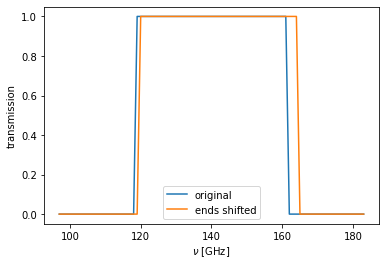

In [60]:
shift_low = 1  # needed resolution of 1 GHz since this is the present resolution on HWP parameters
shift_high = 3
shift_center = 2

bandpass_parameters = {
            "band_type": "top-hat",
            "band_low_edge": 119,
            "band_high_edge": 161,
            "bandcenter_ghz": channelinfo.bandcenter_ghz,
        }

bandpass_parameters_sh = {
            "band_type": "top-hat",
            "band_low_edge": 119 + shift_low,
            "band_high_edge": 161 + shift_high,
            "bandcenter_ghz": channelinfo.bandcenter_ghz+shift_center,
        }

transmission = lbs.out_of_band_analysis.bandpass_template_module.bandpass_profile(
    Nu, bandpass_parameters
)

transmission_shifted = (
    lbs.out_of_band_analysis.bandpass_template_module.bandpass_profile(
        Nu, bandpass_parameters_sh
    )
)
plt.plot(transmission[0], transmission[1], label="original")
plt.plot(transmission_shifted[0], transmission_shifted[1], label="ends shifted")
plt.xlabel(r"$\nu$ [GHz]")
plt.ylabel("transmission")
plt.legend()

In [61]:
par = {
    "hwp_sys": {
        "band_filename": "MFT_140_h_beta_z_wider.txt",
        "band_filename_solver": "MFT_140_h_beta_z_wider.txt",  # same as tod parameters
        "bandpass": {
            "band_type": "top-hat-exp",
            "band_alpha": 0.9,
            "band_beta": 0.9,
            "band_low_edge": 119 + shift_low,
            "band_high_edge": 161 + shift_high,
            "bandcenter_ghz": channelinfo.bandcenter_ghz + shift_center,
        },
        "bandpass_solver": {
            "band_type": "top-hat",
            "band_low_edge": 119,
            "band_high_edge": 161,
            "bandcenter_ghz": channelinfo.bandcenter_ghz,
        },
        "include_beam_throughput": False,
    }
}

In [62]:
(obs_sh,) = sim.create_observations(detectors=dets)
sim.parameter_file = par  # setting the parameter file
hwp_sys_band = lbs.HwpSysAndBandpass(sim)

In [63]:
hwp_sys_band.set_parameters(  # maps=maps,    # ---> to use without band integration
    integrate_in_band=True,
    integrate_in_band_solver=True,
    correct_in_solver=True,
    built_map_on_the_fly=False,
    nside=nside,
    Mbsparams=Mbsparams,
    Channel=channelinfo,
)

[2022-10-27 18:19:45,459 WARNING MPI#0000] Apodizing w/ exp profile
[2022-10-27 18:19:45,460 INFO MPI#0000] using the passed instrument to generate maps
[2022-10-27 18:19:45,461 INFO MPI#0000] generating and saving cmb simulations
[2022-10-27 18:19:45,476 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:19:45,477 INFO MPI#0000] -> fwhm is 0.000000 arcmin
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /home/sgiardie/lbs/out_of_band/litebird_sim/litebird_sim/out_of_band_analysis/examples/tutorial/cmb/0000/cmb_0000_date_221027.fits
  warnings.warn(f"Access data from {full_path}")
[2022-10-27 18:19:45,504 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2022-10-27 18:19:45,506 INFO MPI#0000] NSIDE = 64
[2022-10-27 18:19:45,507 INFO MPI#0000] ORDERING = RING in fits file
[2022-10-27 18:19:45,508 INFO MPI#0000] INDXSC

***************** D
***************** D
***************** D


[2022-10-27 18:19:45,705 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:19:45,707 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:19:45,709 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:19:45,711 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:19:45,753 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:19:45,754 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:19:45,756 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:19:45,757 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:19:45,801 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:19:45,802 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:19:45,803 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:19:45,803 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:19:45,843 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:19:45,843

[2022-10-27 18:19:47,098 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:19:47,100 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:19:47,150 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:19:47,151 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:19:47,153 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:19:47,154 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:19:47,194 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:19:47,196 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:19:47,199 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:19:47,201 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:19:47,235 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:19:47,236 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:19:47,238 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:19:47,240 

[2022-10-27 18:19:48,351 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:19:48,353 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:19:48,356 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:19:48,357 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:19:48,398 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:19:48,400 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:19:48,402 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:19:48,403 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:19:48,434 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:19:48,436 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:19:48,439 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:19:48,440 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:19:48,497 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:19:48,499

[2022-10-27 18:19:49,602 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:19:49,603 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:19:49,650 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:19:49,652 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:19:49,655 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:19:49,657 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:19:49,741 INFO MPI#0000] generating and saving fg simulations
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
[2022-10-27 18:19:49,753 INFO MPI#0000] NSIDE = 512
[2022-10-27 18:19:49,756 INFO MPI#0000] ORDERING = RING in fits file
[2022-10-27 18:19:49,758 INFO MPI#0000] INDXSCHM = IMPLICIT
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/si

[2022-10-27 18:19:53,771 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:19:53,773 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:19:53,775 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:19:53,933 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:19:53,935 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:19:53,937 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:19:53,939 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:19:54,104 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:19:54,106 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:19:54,109 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:19:54,111 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:19:54,262 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:19:54,264 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:19:54,266 INFO MPI#0000

[2022-10-27 18:19:58,528 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:19:58,683 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:19:58,685 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:19:58,687 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:19:58,689 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:19:58,847 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:19:58,849 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:19:58,851 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:19:58,853 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:19:59,011 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:19:59,012 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:19:59,015 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:19:59,017 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:19:59,183 INFO MPI#0000]

[2022-10-27 18:20:03,171 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:20:03,173 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:20:03,175 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:20:03,322 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:20:03,324 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:20:03,326 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:20:03,328 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:20:03,494 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:20:03,496 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:20:03,499 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:20:03,501 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:20:03,651 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:20:03,653 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:20:03,656 INFO MPI#0000

[2022-10-27 18:20:06,811 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:20:06,812 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:20:06,922 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:20:06,924 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:20:06,927 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:20:06,929 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:20:07,035 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:20:07,037 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:20:07,039 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:20:07,042 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:20:07,142 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:20:07,144 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:20:07,146 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:20:07,148 

[2022-10-27 18:20:10,032 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:20:10,032 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:20:10,034 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:20:10,034 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:20:10,153 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:20:10,153 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:20:10,155 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:20:10,155 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:20:10,255 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:20:10,256 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:20:10,258 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:20:10,258 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:20:10,361 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:20:10,362

[2022-10-27 18:20:13,123 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:20:13,129 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:20:13,234 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:20:13,239 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:20:13,242 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:20:13,245 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:20:13,347 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:20:13,353 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:20:13,356 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:20:13,362 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:20:13,460 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:20:13,462 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:20:13,465 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:20:13,468 

[2022-10-27 18:20:16,850 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:20:16,852 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:20:16,854 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:20:16,857 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:20:17,102 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:20:17,104 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:20:17,107 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:20:17,109 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:20:17,350 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:20:17,352 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:20:17,355 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:20:17,357 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:20:17,606 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:20:17,608

[2022-10-27 18:20:23,886 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:20:23,888 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:20:24,148 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:20:24,150 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:20:24,153 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:20:24,154 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:20:24,404 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:20:24,406 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:20:24,408 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:20:24,410 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:20:24,649 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:20:24,651 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:20:24,653 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:20:24,656 

[2022-10-27 18:20:31,090 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:20:31,099 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:20:31,103 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:20:31,105 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:20:31,394 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:20:31,409 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:20:31,410 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:20:31,411 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:20:31,681 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:20:31,682 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:20:31,683 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:20:31,684 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:20:31,983 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:20:31,991

[2022-10-27 18:20:38,535 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:20:38,537 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:20:38,776 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:20:38,778 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:20:38,780 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:20:38,783 INFO MPI#0000] -> fwhm is 0.000000 arcmin
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/ame_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
[2022-10-27 18:20:38,803 INFO MPI#0000] NSIDE = 512
[2022-10-27 18:20:38,805 INFO MPI#0000] ORDERING = RING in fits file
[2022-10-27 18:20:38,807 INFO MPI#0000] INDXSCHM = IMPLICIT
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/ame_n

[2022-10-27 18:20:42,968 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:20:42,970 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:20:42,972 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:20:42,974 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:20:43,135 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:20:43,137 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:20:43,139 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:20:43,141 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:20:43,310 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:20:43,313 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:20:43,315 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:20:43,317 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:20:43,477 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:20:43,479

[2022-10-27 18:20:47,585 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:20:47,587 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:20:47,759 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:20:47,761 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:20:47,763 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:20:47,765 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:20:47,935 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:20:47,937 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:20:47,939 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:20:47,942 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:20:48,108 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:20:48,110 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:20:48,113 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:20:48,114 

[2022-10-27 18:20:52,279 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:20:52,282 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:20:52,284 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:20:52,284 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:20:52,445 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:20:52,446 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:20:52,447 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:20:52,448 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:20:52,611 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:20:52,612 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:20:52,613 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:20:52,614 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:20:52,784 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:20:52,785

In [64]:
hwp_sys_band.fill_tod(obs = obs_sh, pointings = pointings, hwp_radpsec = hwp_radpsec)

let's compare the tod produced with shifts to the 'normal' one

Text(0, 0.5, 'tod w/ shifts - tod w/o shifts')

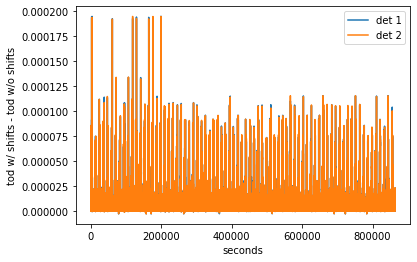

In [65]:
plt.plot(obs_sh.tod[0] - obs_w.tod[0], label="det 1")
plt.plot(obs_sh.tod[1] - obs_w.tod[1], label="det 2")
plt.legend()
plt.xlabel("seconds")
plt.ylabel("tod w/ shifts - tod w/o shifts")

There is overall a ~ percent difference between the two. The difference is due to the foregrounds, which are frequency dependent, and the interplay with chromatic HWP non-idealities

## To make a map

before doing that, let's increase `mission_time_days` to 200 and execute again the first cells

In [9]:
(obs,) = sim.create_observations(detectors=dets)

(pointings,) = lbs.get_pointings_for_observations(
    sim.observations,
    spin2ecliptic_quats=sim.spin2ecliptic_quats,
    bore2spin_quat=instrumentinfo.bore2spin_quat,
    hwp= None,
    #lbs.IdealHWP(
    #    inst_info.hwp_rpm * 2 * np.pi / 60,
    #),  # applies hwp rotation angle to the polarization angle
    store_pointings_in_obs=True,  # if True, stores colatitude and longitude in
    # sim.observations[:].pointings, and the polarization angle in
    # sim.observations[:].psi
)

In [10]:
par = {
    "hwp_sys": {
        "band_filename": "MFT_140_h_beta_z_wider.txt",
        "band_filename_solver": "MFT_140_h_beta_z_wider.txt",  # same as tod parameters
        "bandpass": {
            "band_type": "top-hat",
            "band_low_edge": 119,
            "band_high_edge": 161,
            "bandcenter_ghz": channelinfo.bandcenter_ghz,
        },
        "bandpass_solver": {
            "band_type": "top-hat",
            "band_low_edge": 119,
            "band_high_edge": 161,
            "bandcenter_ghz": channelinfo.bandcenter_ghz,
        },
        "include_beam_throughput": False,
    }
}

In [11]:
sim.parameter_file = par  # setting the parameter file
hwp_sys_band = lbs.HwpSysAndBandpass(sim)

In [12]:
hwp_sys_band.set_parameters(  # maps=maps,    # ---> to use without band integration
    integrate_in_band=True,
    correct_in_solver=True,
    integrate_in_band_solver=True,
    built_map_on_the_fly=True,
    nside=nside,
    Mbsparams=Mbsparams,
    Channel=channelinfo,
)

[2022-10-27 17:59:59,095 WARNING MPI#0000] Band is not apodized
[2022-10-27 17:59:59,096 INFO MPI#0000] using the passed instrument to generate maps
[2022-10-27 17:59:59,097 INFO MPI#0000] generating and saving cmb simulations
[2022-10-27 17:59:59,110 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 17:59:59,111 INFO MPI#0000] -> fwhm is 0.000000 arcmin
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /home/sgiardie/lbs/out_of_band/litebird_sim/litebird_sim/out_of_band_analysis/examples/tutorial/cmb/0000/cmb_0000_date_221027.fits
  warnings.warn(f"Access data from {full_path}")
[2022-10-27 17:59:59,142 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2022-10-27 17:59:59,145 INFO MPI#0000] NSIDE = 64
[2022-10-27 17:59:59,146 INFO MPI#0000] ORDERING = RING in fits file
[2022-10-27 17:59:59,147 INFO MPI#0000] INDXSCHM =

***************** D
***************** D
***************** D


[2022-10-27 17:59:59,353 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 17:59:59,355 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 17:59:59,357 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 17:59:59,358 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 17:59:59,402 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 17:59:59,404 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 17:59:59,406 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 17:59:59,408 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 17:59:59,456 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 17:59:59,458 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 17:59:59,461 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 17:59:59,463 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 17:59:59,502 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 17:59:59,504

[2022-10-27 18:00:00,652 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:00:00,652 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:00:00,700 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:00:00,700 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:00:00,702 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:00:00,703 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:00:00,737 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:00:00,737 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:00:00,739 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:00:00,739 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:00:00,778 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:00:00,779 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:00:00,780 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:00:00,781 

[2022-10-27 18:00:01,827 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:00:01,828 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:00:01,831 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:00:01,833 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:00:01,874 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:00:01,876 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:00:01,879 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:00:01,881 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:00:01,921 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:00:01,923 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:00:01,925 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:00:01,927 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:00:01,959 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:00:01,961

[2022-10-27 18:00:03,007 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:00:03,009 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:00:03,041 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:00:03,043 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:00:03,046 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:00:03,048 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:00:03,134 INFO MPI#0000] generating and saving fg simulations
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
[2022-10-27 18:00:03,169 INFO MPI#0000] NSIDE = 512
[2022-10-27 18:00:03,170 INFO MPI#0000] ORDERING = RING in fits file
[2022-10-27 18:00:03,172 INFO MPI#0000] INDXSCHM = IMPLICIT
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/si

[2022-10-27 18:00:08,764 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:00:08,767 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:00:08,768 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:00:08,924 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:00:08,926 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:00:08,929 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:00:08,931 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:00:09,090 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:00:09,092 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:00:09,094 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:00:09,096 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:00:09,268 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:00:09,270 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:00:09,272 INFO MPI#0000

[2022-10-27 18:00:13,357 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:00:13,509 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:00:13,510 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:00:13,512 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:00:13,512 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:00:13,691 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:00:13,692 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:00:13,694 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:00:13,694 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:00:13,871 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:00:13,873 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:00:13,875 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:00:13,877 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:00:14,051 INFO MPI#0000]

[2022-10-27 18:00:16,822 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:00:16,825 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:00:16,826 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:00:16,880 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:00:16,882 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:00:16,885 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:00:16,886 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:00:16,938 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:00:16,940 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:00:16,943 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:00:16,945 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:00:16,992 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:00:16,994 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:00:16,996 INFO MPI#0000

[2022-10-27 18:00:20,342 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:00:20,344 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:00:20,421 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:00:20,423 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:00:20,425 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:00:20,427 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:00:20,525 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:00:20,527 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:00:20,529 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:00:20,531 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:00:20,666 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:00:20,672 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:00:20,675 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:00:20,678 

[2022-10-27 18:00:22,810 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:00:22,812 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:00:22,815 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:00:22,817 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:00:22,970 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:00:22,972 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:00:22,974 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:00:22,976 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:00:23,080 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:00:23,082 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:00:23,084 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:00:23,088 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:00:23,175 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:00:23,177

[2022-10-27 18:00:25,914 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:00:25,915 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:00:26,032 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:00:26,034 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:00:26,036 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:00:26,038 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:00:26,142 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:00:26,144 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:00:26,146 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:00:26,148 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:00:26,258 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:00:26,260 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:00:26,262 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:00:26,264 

[2022-10-27 18:00:32,143 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:00:32,144 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:00:32,146 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:00:32,147 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:00:32,422 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:00:32,424 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:00:32,426 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:00:32,428 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:00:32,687 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:00:32,689 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:00:32,691 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:00:32,693 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:00:32,969 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:00:32,970

[2022-10-27 18:00:39,430 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:00:39,432 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:00:39,680 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:00:39,682 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:00:39,684 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:00:39,688 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:00:39,940 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:00:39,942 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:00:39,944 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:00:39,946 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:00:40,199 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:00:40,201 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:00:40,203 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:00:40,205 

[2022-10-27 18:00:46,725 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:00:46,727 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:00:46,729 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:00:46,731 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:00:46,990 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:00:46,997 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:00:47,000 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:00:47,002 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:00:47,254 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:00:47,256 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:00:47,258 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:00:47,262 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:00:47,512 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:00:47,514

[2022-10-27 18:00:54,002 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:00:54,004 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:00:54,253 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:00:54,255 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:00:54,257 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:00:54,259 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:00:54,513 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:00:54,515 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:00:54,518 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:00:54,520 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:00:54,774 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:00:54,776 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:00:54,779 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:00:54,781 

[2022-10-27 18:01:02,634 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:01:02,636 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:01:02,639 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:01:02,641 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:01:02,809 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:01:02,811 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:01:02,813 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:01:02,815 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:01:02,968 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:01:02,970 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:01:02,972 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:01:02,974 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:01:03,141 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:01:03,143

[2022-10-27 18:01:07,319 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:01:07,321 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:01:07,494 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:01:07,496 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:01:07,499 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:01:07,501 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:01:07,672 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:01:07,674 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:01:07,677 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:01:07,679 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:01:07,831 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:01:07,837 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:01:07,840 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:01:07,842 

[2022-10-27 18:01:12,092 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:01:12,093 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:01:12,096 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:01:12,098 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:01:12,264 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:01:12,266 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:01:12,268 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:01:12,270 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:01:12,437 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:01:12,439 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:01:12,441 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:01:12,443 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:01:12,614 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:01:12,616

In [13]:
hwp_sys_band.fill_tod(obs = obs,  hwp_radpsec = hwp_radpsec,) #pointings)

In [14]:
maps = hwp_sys_band.make_map([obs])

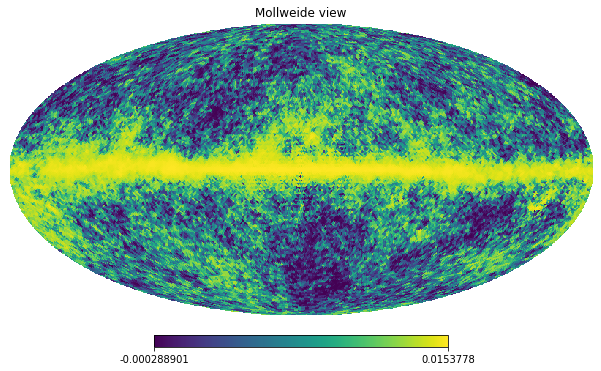

In [15]:
hp.mollview(maps[0], norm="hist")

let's try to subtract to that the input maps, integrated in band like the tod:

In [16]:
int_maps = np.zeros_like(hwp_sys_band.maps)
for i in range(int_maps.shape[0]):
    int_maps[i] = hwp_sys_band.cmb2bb[i] * hwp_sys_band.maps[i]

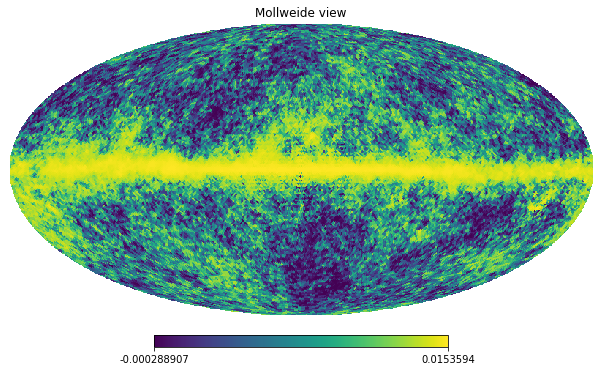

In [17]:
summed_maps = int_maps.sum(axis=0)
hp.mollview(summed_maps[0], norm="hist")

The difference between the output and the integral in frequency of band * input map is not null because of the chromaticity of FG and HWP+bandpass parameters coupled to the mapmaking procedure. The CMB contribution is perfectly canceled out

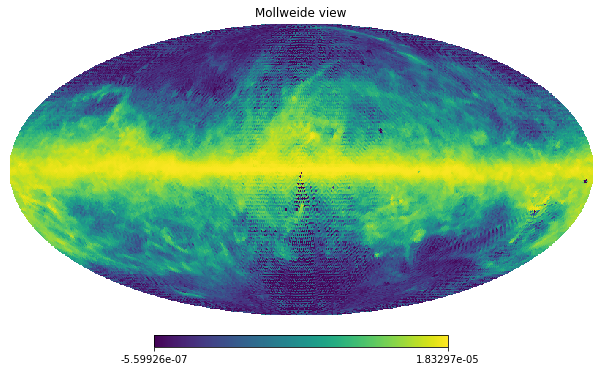

In [18]:
hp.mollview(maps[0] - summed_maps[0], norm="hist")

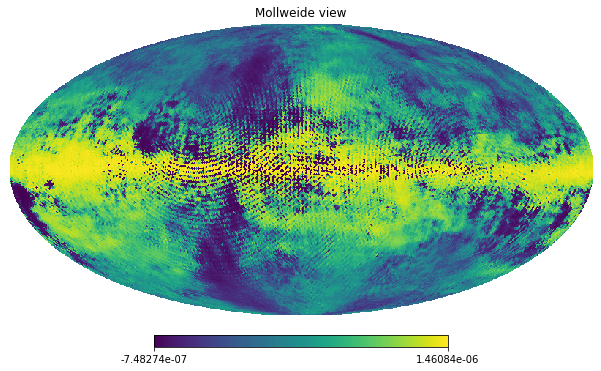

In [19]:
hp.mollview(maps[1] - summed_maps[1], norm="hist")

let's consider now a mismatch in the band between tod and solver:

In [20]:
par = {
    "hwp_sys": {
        "band_filename": "MFT_140_h_beta_z_wider.txt",
        "band_filename_solver": "MFT_140_h_beta_z_wider.txt",  # same as tod parameters
        "bandpass": {
            "band_type": "top-hat-exp",
            "band_alpha": 0.9,
            "band_beta": 0.9,
            "band_low_edge": 119,
            "band_high_edge": 161,
            "bandcenter_ghz": channelinfo.bandcenter_ghz,
        },
        "bandpass_solver": {
            "band_type": "top-hat",
            "band_low_edge": 119,
            "band_high_edge": 161,
            "bandcenter_ghz": channelinfo.bandcenter_ghz,
        },
        "include_beam_throughput": False,
    }
}

In [21]:
(obs_m,) = sim.create_observations(detectors=dets)
sim.parameter_file = par  # setting the parameter file
hwp_sys_band = lbs.HwpSysAndBandpass(sim)

In [22]:
hwp_sys_band.set_parameters(  # maps=maps,    # ---> to use without band integration
    integrate_in_band=True,
    correct_in_solver=True,
    integrate_in_band_solver=True,
    built_map_on_the_fly=True,
    nside=nside,
    Mbsparams=Mbsparams,
    Channel=channelinfo,
)

[2022-10-27 18:06:08,109 WARNING MPI#0000] Apodizing w/ exp profile
[2022-10-27 18:06:08,110 INFO MPI#0000] using the passed instrument to generate maps
[2022-10-27 18:06:08,111 INFO MPI#0000] generating and saving cmb simulations
[2022-10-27 18:06:08,123 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:06:08,124 INFO MPI#0000] -> fwhm is 0.000000 arcmin
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /home/sgiardie/lbs/out_of_band/litebird_sim/litebird_sim/out_of_band_analysis/examples/tutorial/cmb/0000/cmb_0000_date_221027.fits
  warnings.warn(f"Access data from {full_path}")
[2022-10-27 18:06:08,162 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2022-10-27 18:06:08,171 INFO MPI#0000] NSIDE = 64
[2022-10-27 18:06:08,172 INFO MPI#0000] ORDERING = RING in fits file
[2022-10-27 18:06:08,173 INFO MPI#0000] INDXSC

***************** D
***************** D
***************** D


[2022-10-27 18:06:08,389 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:06:08,389 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:06:08,399 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:06:08,399 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:06:08,437 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:06:08,437 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:06:08,439 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:06:08,439 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:06:08,482 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:06:08,482 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:06:08,484 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:06:08,485 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:06:08,527 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:06:08,528

[2022-10-27 18:06:09,601 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:06:09,602 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:06:09,641 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:06:09,641 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:06:09,643 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:06:09,643 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:06:09,680 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:06:09,681 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:06:09,682 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:06:09,683 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:06:09,722 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:06:09,723 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:06:09,724 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:06:09,724 

[2022-10-27 18:06:10,783 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:06:10,784 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:06:10,785 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:06:10,785 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:06:10,833 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:06:10,833 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:06:10,835 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:06:10,835 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:06:10,904 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:06:10,906 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:06:10,907 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:06:10,907 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:06:10,960 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:06:10,962

[2022-10-27 18:06:12,291 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:06:12,294 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:06:12,327 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:06:12,329 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:06:12,332 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:06:12,335 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:06:12,420 INFO MPI#0000] generating and saving fg simulations
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
[2022-10-27 18:06:12,425 INFO MPI#0000] NSIDE = 512
[2022-10-27 18:06:12,427 INFO MPI#0000] ORDERING = RING in fits file
[2022-10-27 18:06:12,429 INFO MPI#0000] INDXSCHM = IMPLICIT
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/si

[2022-10-27 18:06:16,103 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:06:16,107 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:06:16,116 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:06:16,363 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:06:16,366 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:06:16,369 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:06:16,372 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:06:16,596 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:06:16,598 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:06:16,601 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:06:16,604 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:06:16,796 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:06:16,799 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:06:16,801 INFO MPI#0000

[2022-10-27 18:06:21,057 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:06:21,252 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:06:21,253 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:06:21,255 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:06:21,256 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:06:21,467 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:06:21,469 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:06:21,472 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:06:21,474 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:06:21,680 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:06:21,682 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:06:21,685 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:06:21,687 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:06:21,934 INFO MPI#0000]

[2022-10-27 18:06:26,222 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:06:26,224 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:06:26,225 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:06:26,385 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:06:26,386 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:06:26,388 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:06:26,389 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:06:26,567 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:06:26,568 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:06:26,570 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:06:26,571 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:06:26,728 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:06:26,729 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:06:26,730 INFO MPI#0000

[2022-10-27 18:06:29,874 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:06:29,875 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:06:30,004 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:06:30,005 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:06:30,006 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:06:30,007 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:06:30,106 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:06:30,107 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:06:30,108 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:06:30,109 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:06:30,233 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:06:30,234 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:06:30,236 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:06:30,236 

[2022-10-27 18:06:33,187 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:06:33,188 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:06:33,189 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:06:33,190 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:06:33,299 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:06:33,300 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:06:33,301 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:06:33,302 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:06:33,416 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:06:33,417 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:06:33,418 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:06:33,419 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:06:33,531 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:06:33,532

[2022-10-27 18:06:36,335 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:06:36,337 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:06:36,451 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:06:36,453 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:06:36,456 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:06:36,458 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:06:36,558 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:06:36,560 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:06:36,563 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:06:36,565 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:06:36,675 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:06:36,677 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:06:36,680 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:06:36,682 

[2022-10-27 18:06:40,097 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:06:40,099 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:06:40,102 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:06:40,104 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:06:40,369 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:06:40,371 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:06:40,374 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:06:40,376 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:06:40,630 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:06:40,632 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:06:40,635 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:06:40,637 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:06:40,898 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:06:40,904

[2022-10-27 18:06:47,203 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:06:47,203 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:06:47,455 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:06:47,456 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:06:47,458 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:06:47,458 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:06:47,721 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:06:47,721 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:06:47,723 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:06:47,724 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:06:47,973 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:06:47,974 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:06:47,976 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:06:47,976 

[2022-10-27 18:06:54,886 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:06:54,888 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:06:54,890 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:06:54,892 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:06:55,212 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:06:55,214 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:06:55,216 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:06:55,218 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:06:55,420 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:06:55,422 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:06:55,425 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:06:55,427 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:06:55,623 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:06:55,625

[2022-10-27 18:07:01,909 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:07:01,911 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:07:02,182 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:07:02,184 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:07:02,187 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:07:02,189 INFO MPI#0000] -> fwhm is 0.000000 arcmin
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/ame_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
[2022-10-27 18:07:02,196 INFO MPI#0000] NSIDE = 512
[2022-10-27 18:07:02,198 INFO MPI#0000] ORDERING = RING in fits file
[2022-10-27 18:07:02,200 INFO MPI#0000] INDXSCHM = IMPLICIT
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/ame_n

[2022-10-27 18:07:06,454 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:07:06,456 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:07:06,458 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:07:06,460 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:07:06,626 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:07:06,633 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:07:06,642 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:07:06,644 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:07:06,786 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:07:06,788 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:07:06,791 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:07:06,795 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:07:06,934 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:07:06,936

[2022-10-27 18:07:11,534 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:07:11,536 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:07:11,701 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:07:11,703 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:07:11,706 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:07:11,708 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:07:11,868 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:07:11,870 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:07:11,873 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:07:11,875 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:07:12,053 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:07:12,055 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:07:12,058 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:07:12,060 

[2022-10-27 18:07:16,337 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:07:16,339 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:07:16,342 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:07:16,344 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:07:16,483 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:07:16,485 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:07:16,487 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:07:16,489 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:07:16,657 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:07:16,659 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-10-27 18:07:16,661 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-10-27 18:07:16,663 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-10-27 18:07:16,829 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-10-27 18:07:16,831

In [23]:
hwp_sys_band.fill_tod(obs = obs_m, pointings = pointings, hwp_radpsec = hwp_radpsec)

In [24]:
maps_mism = hwp_sys_band.make_map([obs_m])

In [25]:
int_maps_solver = np.zeros_like(hwp_sys_band.maps)
for i in range(int_maps.shape[0]):
    int_maps_solver = hwp_sys_band.cmb2bb_solver[i] * hwp_sys_band.maps[i]
summed_maps_solver = int_maps_solver.sum(axis=0)

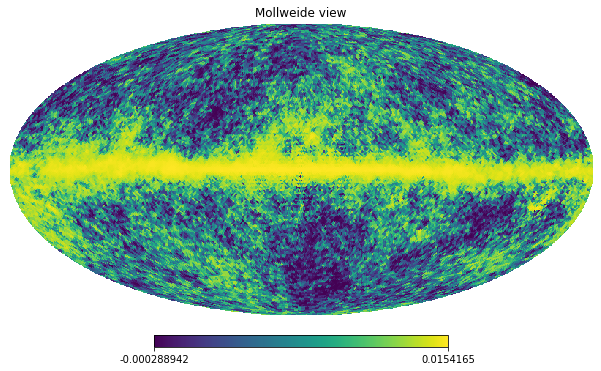

In [26]:
hp.mollview(maps_mism[0] - summed_maps_solver[0], norm="hist")

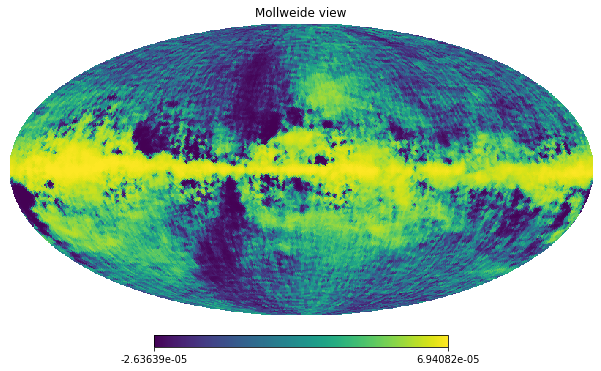

In [28]:
hp.mollview(maps_mism[1] - summed_maps_solver[1], norm="hist")

we see that we have a residual of CMB in those maps, due to the bandpass mismatch. Let's try and derive the spectra of those residual maps

In [29]:
res_nomism = maps - summed_maps
res_mism = maps_mism - summed_maps_solver

In [30]:
cl_nomism = hp.anafast(res_nomism) * 1e12
cl_mism = hp.anafast(res_mism) * 1e12
ell = np.arange(cl_mism.shape[1])

Text(0.5, 1.0, 'Power spectra of residuals')

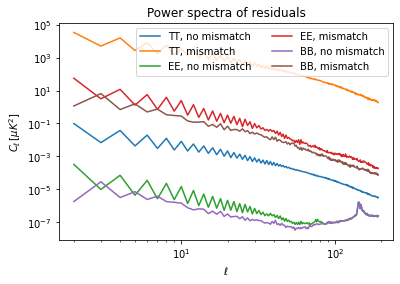

In [31]:
plt.loglog(ell[2:], cl_nomism[0, 2:], label="TT, no mismatch")
plt.loglog(ell[2:], cl_mism[0, 2:], label="TT, mismatch")
plt.loglog(ell[2:], cl_nomism[1, 2:], label="EE, no mismatch")
plt.loglog(ell[2:], cl_mism[1, 2:], label="EE, mismatch")
plt.loglog(ell[2:], cl_nomism[2, 2:], label="BB, no mismatch")
plt.loglog(ell[2:], cl_mism[2, 2:], label="BB, mismatch")
plt.legend(ncol=2, loc="upper right")
plt.ylabel(r"$C_{\ell} \, [\mu K^2]$")
plt.xlabel("$\ell$")
plt.title("Power spectra of residuals")

The residual maps are not masked so the main contribution in all cases comes from the galactic plane.
According to eq. 38 of https://arxiv.org/abs/2106.08031v3, using the integral in frequency of the input maps is not the best way to minimize the residual maps and to make it dependent just on the mismatch between the bandpasses and the HWP parameters in the tod and the solver. The firs map we have done can act as a template map, having bandpass_tod = bandpass_solver and the same bandpass solver as the second map

Text(0.5, 1.0, 'Power spectra of residuals')

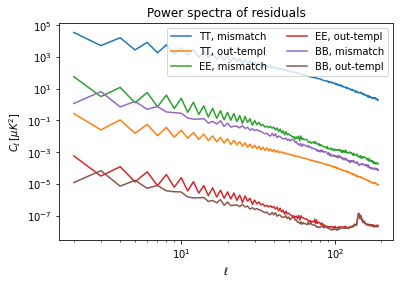

In [32]:
cl_res = hp.anafast(maps_mism - maps) * 1e12
plt.loglog(ell[2:],cl_mism[0,2:],label = 'TT, mismatch')
plt.loglog(ell[2:], cl_res[0, 2:], label="TT, out-templ")
plt.loglog(ell[2:],cl_mism[1,2:],label = 'EE, mismatch')
plt.loglog(ell[2:], cl_res[1, 2:], label="EE, out-templ")
plt.loglog(ell[2:],cl_mism[2,2:],label = 'BB, mismatch')
plt.loglog(ell[2:], cl_res[2, 2:], label="BB, out-templ")
plt.legend(ncol=2, loc="upper right")
plt.ylabel(r"$C_{\ell} \, [\mu K^2]$")
plt.xlabel("$\ell$")
plt.title("Power spectra of residuals")